In [254]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


import torch
from torch import nn
import pytorch_model_summary as pms 

from torch.utils.data import TensorDataset, DataLoader

from pytorchtools import EarlyStopping

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cpu device


In [255]:
X = pd.read_csv('data/virseeker/rnn_train.csv', header = None ).iloc[:8999,]
y = pd.read_csv('data/virseeker/label_train.csv', header = None)
X.shape , y.shape

((8999, 500), (8999, 2))

In [256]:
y[0].value_counts()

0
1    4500
0    4499
Name: count, dtype: int64

In [257]:
IDX = np.arange( y.shape[0] )
np.random.shuffle(IDX)

valid_fraction = 0.1
valid_N = int( len( IDX ) * valid_fraction )

X_train = X.loc[ IDX[valid_N:] , : ]
X_valid = X.loc[ IDX[:valid_N] , : ]

y_train = y.loc[ IDX[valid_N:] , 0 ]
y_valid = y.loc[ IDX[:valid_N] , 0 ]



In [258]:
valid_N

899

In [259]:
y_valid.shape , y_train.shape

((899,), (8100,))

In [260]:
X_train = torch.LongTensor( np.array(X_train)-1 )
y_train = torch.Tensor( np.array(y_train) )
dataset_train = TensorDataset(X_train,y_train)
train_dataloader = DataLoader(dataset_train , batch_size=128)

In [261]:
X_valid = torch.LongTensor( np.array(X_valid)-1 )
y_valid = torch.Tensor( np.array(y_valid) )
dataset_valid = TensorDataset(X_valid,y_valid)
valid_dataloader = DataLoader(dataset_valid , batch_size=128)

In [262]:
class classifier_LSTM(nn.Module):
    
    def __init__(self , num_classes = 5 , 
                        hidden_dim=3 ,
                        dropout_fraction = 0.1):
        super().__init__()
        
        self.num_classes = num_classes
        self.rnn = nn.LSTM( input_size = num_classes,
                          hidden_size = hidden_dim,
                          num_layers = 1)
        
        self.classifier = nn.Sequential(nn.Linear( hidden_dim,1 ) , 
                                        nn.Sigmoid())

        
    def forward(self, sequence):
        
        ## x is made of a single 1D sequence of arbitrary length
        # assert len( x.shape ) == 1
        
        x = nn.functional.one_hot( sequence ,
                                   num_classes = self.num_classes )
        x = x.type('torch.FloatTensor')
        
        x,_ = self.rnn( x )
        
        
        ## we grab the last element of each sequence to feed it to the classifier:
        x = x[:,-1,:]
        
        out = self.classifier( x )
        return out.squeeze()



model = classifier_LSTM(num_classes = 4).to(device)
print(model)

classifier_LSTM(
  (rnn): LSTM(4, 3)
  (classifier): Sequential(
    (0): Linear(in_features=3, out_features=1, bias=True)
    (1): Sigmoid()
  )
)


In [263]:
x,y = dataset_train[:5]
pred = model(x)
pred

tensor([0.4234, 0.4452, 0.4610, 0.4487, 0.4726], grad_fn=<SqueezeBackward0>)

In [264]:
y

tensor([0., 1., 1., 0., 0.])

In [265]:
loss_fn(pred,y)

tensor(0.6739, grad_fn=<BinaryCrossEntropyBackward0>)

In [266]:
((pred>0.5) == y).sum()

tensor(3)

In [267]:
def train(dataloader, model, loss_fn, optimizer , echo = True):
    
    size = len(dataloader.dataset) # how many batches do we have
    model.train() #     Sets the module in training mode.
    
    for batch, (X, y) in enumerate(dataloader): # for each batch
        X, y = X.to(device), y.to(device) # send the data to the GPU or whatever device you use for training

        # Compute prediction error
        pred = model(X)              # prediction for the model -> forward pass
        loss = loss_fn(pred, y)      # loss function from these prediction

        # Backpropagation
        loss.backward()              # backward propagation 
        #                            https://ml-cheatsheet.readthedocs.io/en/latest/backpropagation.html
        #                            https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html
        
        optimizer.step()             
        optimizer.zero_grad()        # reset the gradients
                                     # https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch

        if echo:
            current =  (batch + 1) * len(X)
            print(f"loss: {loss.item():>7f}  [{current:>5d}/{size:>5d}]")
    
    # return the last batch loss:
    return loss.item()

In [268]:
def valid(dataloader, model, loss_fn, echo = True):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval() #     Sets the module in evaluation mode
    valid_loss, correct = 0, 0
    with torch.no_grad(): ## disables tracking of gradient: prevent accidental training + speeds up computation
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            valid_loss += loss_fn(pred, y).item()  ## accumulating the loss function over the batches
            
            correct += ((pred>0.5) == y).sum().item() ## counting number of true predictions
            
    valid_loss /= num_batches
    correct /= size
    if echo:
        print(f"Valid Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {valid_loss:>8f} \n")
    ## return the average loss / batch
    return valid_loss


 ### actual training

In [273]:
model = classifier_LSTM( num_classes = 4 , 
                        hidden_dim= 128,
                        dropout_fraction = 0.1).to(device)

# list of loss functions https://pytorch.org/docs/stable/nn.html#loss-functions
# https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#toc-entry-1
loss_fn = nn.BCELoss()

# optimizer https://pytorch.org/docs/stable/optim.html
# https://ml-cheatsheet.readthedocs.io/en/latest/optimizers.html#sgd
optimizer = torch.optim.Adam(model.parameters(), lr= 10**-4 )

train_losses = []
valid_losses = []


In [274]:
%%time
train_losses.append( train(train_dataloader, model, loss_fn, optimizer, echo=True) )
valid_losses.append( valid(valid_dataloader, model, loss_fn , echo = True) )


loss: 0.692246  [  128/ 8100]
loss: 0.691434  [  256/ 8100]
loss: 0.690921  [  384/ 8100]
loss: 0.691959  [  512/ 8100]
loss: 0.689907  [  640/ 8100]
loss: 0.698804  [  768/ 8100]
loss: 0.690959  [  896/ 8100]
loss: 0.692382  [ 1024/ 8100]
loss: 0.692292  [ 1152/ 8100]
loss: 0.691437  [ 1280/ 8100]
loss: 0.696530  [ 1408/ 8100]
loss: 0.693348  [ 1536/ 8100]
loss: 0.696363  [ 1664/ 8100]
loss: 0.691826  [ 1792/ 8100]
loss: 0.689753  [ 1920/ 8100]
loss: 0.696901  [ 2048/ 8100]
loss: 0.694364  [ 2176/ 8100]
loss: 0.692533  [ 2304/ 8100]
loss: 0.696727  [ 2432/ 8100]
loss: 0.694395  [ 2560/ 8100]
loss: 0.690980  [ 2688/ 8100]
loss: 0.689498  [ 2816/ 8100]
loss: 0.693351  [ 2944/ 8100]
loss: 0.696460  [ 3072/ 8100]
loss: 0.693956  [ 3200/ 8100]
loss: 0.693471  [ 3328/ 8100]
loss: 0.694704  [ 3456/ 8100]
loss: 0.692302  [ 3584/ 8100]
loss: 0.694279  [ 3712/ 8100]
loss: 0.691503  [ 3840/ 8100]
loss: 0.692421  [ 3968/ 8100]
loss: 0.693343  [ 4096/ 8100]
loss: 0.693342  [ 4224/ 8100]
loss: 0.69

In [275]:
%%time

epochs = 20

for t in range(epochs):
    echo = (t%5 == 0)
    if echo:
        print(f"Epoch {t+1}\n-------------------------------")
    train_losses.append( train(train_dataloader, model, loss_fn, optimizer, echo=False) )
    valid_losses.append( valid(valid_dataloader, model, loss_fn , echo = echo) )
print("Done!")

Epoch 1
-------------------------------
Valid Error: 
 Accuracy: 50.7%, Avg loss: 0.693602 

Epoch 6
-------------------------------
Valid Error: 
 Accuracy: 54.3%, Avg loss: 0.692997 

Epoch 11
-------------------------------
Valid Error: 
 Accuracy: 55.4%, Avg loss: 0.692919 

Epoch 16
-------------------------------
Valid Error: 
 Accuracy: 56.2%, Avg loss: 0.692434 

Done!
CPU times: user 23min 34s, sys: 4min 52s, total: 28min 26s
Wall time: 7min 7s


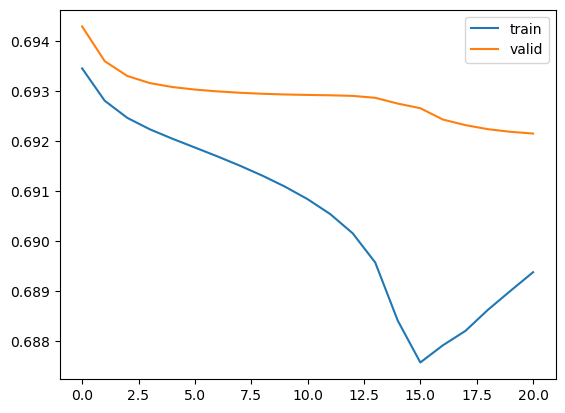

In [276]:
plt.plot( train_losses , label='train' )
plt.plot( valid_losses , label='valid' )
plt.legend()

## trying with a simple classifier

In [214]:
class classifier_D(nn.Module):
    
    def __init__(self , num_classes = 5 , 
                        hidden_dim=3 ,
                        dropout_fraction = 0.1):
        super().__init__()
        
        self.num_classes = num_classes
       
        self.layers = nn.Sequential( nn.Linear( num_classes , hidden_dim ) ,
                                        nn.ReLU(),
                                        nn.Linear( hidden_dim , 1 ) ,
                                        nn.Sigmoid() )

        
    def forward(self, x):
        out = self.layers( x.type('torch.FloatTensor') )
        return out.squeeze()



model = classifier_D(num_classes = 4).to(device)
print(model)

classifier_D(
  (layers): Sequential(
    (0): Linear(in_features=4, out_features=3, bias=True)
    (1): ReLU()
    (2): Linear(in_features=3, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


In [215]:
model = classifier_D( num_classes = 500 , 
                        hidden_dim=32 ,
                        dropout_fraction = 0.25).to(device)

# list of loss functions https://pytorch.org/docs/stable/nn.html#loss-functions
# https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#toc-entry-1
loss_fn = nn.BCELoss()

# optimizer https://pytorch.org/docs/stable/optim.html
# https://ml-cheatsheet.readthedocs.io/en/latest/optimizers.html#sgd
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1) # 0.00001

In [216]:
model

classifier_D(
  (layers): Sequential(
    (0): Linear(in_features=500, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

In [217]:
%%time
train_losses.append( train(train_dataloader, model, loss_fn, optimizer, echo=True) )
valid_losses.append( valid(valid_dataloader, model, loss_fn , echo = True) )


loss: 0.686128  [  128/ 8100]
loss: 0.702792  [  256/ 8100]
loss: 0.702249  [  384/ 8100]
loss: 0.701432  [  512/ 8100]
loss: 0.683425  [  640/ 8100]
loss: 0.692852  [  768/ 8100]
loss: 0.702964  [  896/ 8100]
loss: 0.680643  [ 1024/ 8100]
loss: 0.706761  [ 1152/ 8100]
loss: 0.710505  [ 1280/ 8100]
loss: 0.709749  [ 1408/ 8100]
loss: 0.712573  [ 1536/ 8100]
loss: 0.689250  [ 1664/ 8100]
loss: 0.686767  [ 1792/ 8100]
loss: 0.677645  [ 1920/ 8100]
loss: 0.710043  [ 2048/ 8100]
loss: 0.696183  [ 2176/ 8100]
loss: 0.683496  [ 2304/ 8100]
loss: 0.699655  [ 2432/ 8100]
loss: 0.693532  [ 2560/ 8100]
loss: 0.686555  [ 2688/ 8100]
loss: 0.687145  [ 2816/ 8100]
loss: 0.689685  [ 2944/ 8100]
loss: 0.690965  [ 3072/ 8100]
loss: 0.691080  [ 3200/ 8100]
loss: 0.696838  [ 3328/ 8100]
loss: 0.684216  [ 3456/ 8100]
loss: 0.689371  [ 3584/ 8100]
loss: 0.691514  [ 3712/ 8100]
loss: 0.685675  [ 3840/ 8100]
loss: 0.682789  [ 3968/ 8100]
loss: 0.692128  [ 4096/ 8100]
loss: 0.692306  [ 4224/ 8100]
loss: 0.68

Epoch 1
-------------------------------
Valid Error: 
 Accuracy: 55.4%, Avg loss: 0.681223 

Epoch 11
-------------------------------
Valid Error: 
 Accuracy: 58.0%, Avg loss: 0.677500 

Epoch 21
-------------------------------
Valid Error: 
 Accuracy: 60.4%, Avg loss: 0.712598 

Epoch 31
-------------------------------
Valid Error: 
 Accuracy: 58.7%, Avg loss: 0.746928 

Epoch 41
-------------------------------
Valid Error: 
 Accuracy: 59.8%, Avg loss: 0.693147 

Done!
CPU times: user 17.7 s, sys: 129 ms, total: 17.8 s
Wall time: 4.45 s


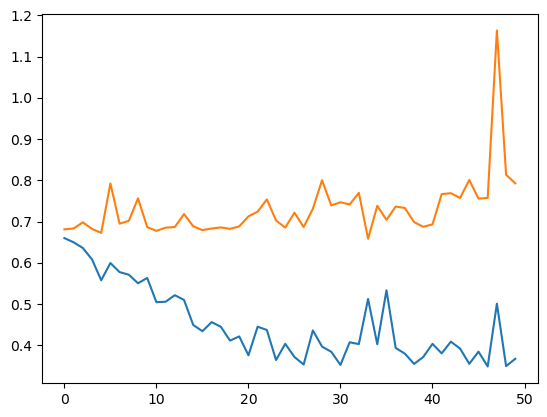

In [218]:
%%time

epochs = 50
train_losses = []
valid_losses = []

for t in range(epochs):
    echo = (t%10 == 0)
    if echo:
        print(f"Epoch {t+1}\n-------------------------------")
    train_losses.append( train(train_dataloader, model, loss_fn, optimizer, echo=False) )
    valid_losses.append( valid(valid_dataloader, model, loss_fn , echo = echo) )
print("Done!")

plt.plot( train_losses , label='train' )
plt.plot( valid_losses , label='valid' )


## trying without one hot encoding


In [277]:
# input_size – The number of expected features in the input x
# hidden_size – The number of features in the hidden state h
# num_layers – Number of recurrent layers. E.g., setting num_layers=2 would mean stacking two GRUs together to form a stacked GRU, with the second GRU taking in outputs of the first GRU and computing the final results. Default: 1
rnn = nn.LSTM(1, 20, 2)

## input data : sequence length , batch size , Hin
input = torch.randn(5, 3, 1)

output, hn = rnn(input)

## output of the last element for each batch
output[-1,:,:]

output.dtype

torch.float32

In [278]:
input

tensor([[[-0.1825],
         [ 0.0221],
         [-1.4980]],

        [[ 2.0474],
         [ 0.0489],
         [-1.2442]],

        [[ 0.5374],
         [ 0.9586],
         [ 1.1338]],

        [[-1.6280],
         [ 0.0341],
         [-0.9171]],

        [[ 0.7682],
         [ 0.3130],
         [ 1.3659]]])

In [281]:
x,y = dataset_train[:5]
x.shape

torch.Size([5, 500])

In [283]:
torch.reshape(x,(5,500,1)).shape

torch.Size([5, 500, 1])

In [284]:
X_train2 = torch.reshape( X_train , ( X_train.shape[0],X_train.shape[1] , 1) )
X_valid2 = torch.reshape( X_valid , ( X_valid.shape[0],X_valid.shape[1] , 1) )

dataset_train2 = TensorDataset(X_train2,y_train)
train_dataloader2 = DataLoader(dataset_train2 , batch_size=128)

dataset_valid2 = TensorDataset(X_valid2,y_valid)
valid_dataloader2 = DataLoader(dataset_valid2 , batch_size=128)

In [287]:
class classifier_LSTM_noOH(nn.Module):
    
    def __init__(self , hidden_dim=3 ,
                        dropout_fraction = 0.1):
        super().__init__()
        

        self.rnn = nn.LSTM( input_size = 1,
                          hidden_size = hidden_dim,
                          num_layers = 1)
        
        self.classifier = nn.Sequential(nn.Linear( hidden_dim,1 ) , 
                                        nn.Sigmoid())

        
    def forward(self, x):
        
        ## x is made of a single 1D sequence of arbitrary length
        # assert len( x.shape ) == 1

        x = x.type('torch.FloatTensor')
        
        x,_ = self.rnn( x )
        
        
        ## we grab the last element of each sequence to feed it to the classifier:
        x = x[:,-1,:]
        
        out = self.classifier( x )
        return out.squeeze()



model = classifier_LSTM_noOH().to(device)
print(model)

classifier_LSTM_noOH(
  (rnn): LSTM(1, 3)
  (classifier): Sequential(
    (0): Linear(in_features=3, out_features=1, bias=True)
    (1): Sigmoid()
  )
)


In [288]:
x,y = dataset_train2[:5]
pred = model(x)
pred

tensor([0.5297, 0.4851, 0.5129, 0.5032, 0.5130], grad_fn=<SqueezeBackward0>)

In [289]:
loss_fn(pred,y)

tensor(0.7129, grad_fn=<BinaryCrossEntropyBackward0>)

 ### actual training

In [291]:
model = classifier_LSTM_noOH( hidden_dim= 128,
                                dropout_fraction = 0.1).to(device)

# list of loss functions https://pytorch.org/docs/stable/nn.html#loss-functions
# https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#toc-entry-1
loss_fn = nn.BCELoss()

# optimizer https://pytorch.org/docs/stable/optim.html
# https://ml-cheatsheet.readthedocs.io/en/latest/optimizers.html#sgd
optimizer = torch.optim.Adam(model.parameters(), lr= 10**-4 )

train_losses = []
valid_losses = []


In [292]:
%%time
train_losses.append( train(train_dataloader2, model, loss_fn, optimizer, echo=True) )
valid_losses.append( valid(valid_dataloader2, model, loss_fn , echo = True) )


loss: 0.694519  [  128/ 8100]
loss: 0.695228  [  256/ 8100]
loss: 0.695759  [  384/ 8100]
loss: 0.694027  [  512/ 8100]
loss: 0.695033  [  640/ 8100]
loss: 0.691148  [  768/ 8100]
loss: 0.694103  [  896/ 8100]
loss: 0.693566  [ 1024/ 8100]
loss: 0.694302  [ 1152/ 8100]
loss: 0.694397  [ 1280/ 8100]
loss: 0.692016  [ 1408/ 8100]
loss: 0.693107  [ 1536/ 8100]
loss: 0.692817  [ 1664/ 8100]
loss: 0.693544  [ 1792/ 8100]
loss: 0.694192  [ 1920/ 8100]
loss: 0.692472  [ 2048/ 8100]
loss: 0.693155  [ 2176/ 8100]
loss: 0.693361  [ 2304/ 8100]
loss: 0.692456  [ 2432/ 8100]
loss: 0.692835  [ 2560/ 8100]
loss: 0.693438  [ 2688/ 8100]
loss: 0.693736  [ 2816/ 8100]
loss: 0.692859  [ 2944/ 8100]
loss: 0.692692  [ 3072/ 8100]
loss: 0.692785  [ 3200/ 8100]
loss: 0.693008  [ 3328/ 8100]
loss: 0.693465  [ 3456/ 8100]
loss: 0.692562  [ 3584/ 8100]
loss: 0.693192  [ 3712/ 8100]
loss: 0.693347  [ 3840/ 8100]
loss: 0.693225  [ 3968/ 8100]
loss: 0.693051  [ 4096/ 8100]
loss: 0.693096  [ 4224/ 8100]
loss: 0.69

In [293]:
%%time

epochs = 20

for t in range(epochs):
    echo = (t%5 == 0)
    if echo:
        print(f"Epoch {t+1}\n-------------------------------")
    train_losses.append( train(train_dataloader2, model, loss_fn, optimizer, echo=False) )
    valid_losses.append( valid(valid_dataloader2, model, loss_fn , echo = echo) )
print("Done!")

Epoch 1
-------------------------------
Valid Error: 
 Accuracy: 53.5%, Avg loss: 0.693045 

Epoch 6
-------------------------------
Valid Error: 
 Accuracy: 56.3%, Avg loss: 0.694501 

Epoch 11
-------------------------------
Valid Error: 
 Accuracy: 57.2%, Avg loss: 0.695898 

Epoch 16
-------------------------------
Valid Error: 
 Accuracy: 56.8%, Avg loss: 0.697171 

Done!
CPU times: user 23min 54s, sys: 4min 33s, total: 28min 28s
Wall time: 7min 7s


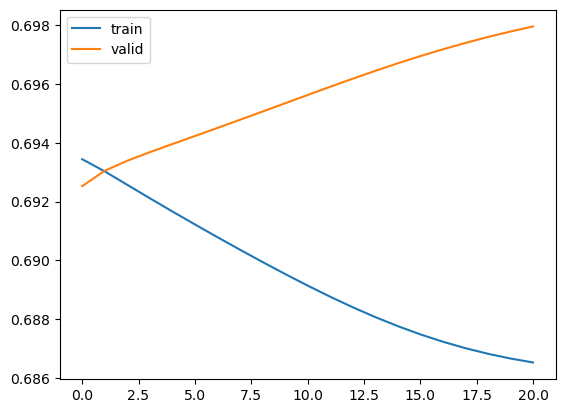

In [294]:
plt.plot( train_losses , label='train' )
plt.plot( valid_losses , label='valid' )
plt.legend()

In [310]:
class classifier_LSTM_embed(nn.Module):
    
    def __init__(self , num_classes = 4 ,
                        embed_dim = 5,
                        hidden_dim=3 ,
                dropout=0.1):
        super().__init__()
        self.embedLayer = torch.nn.Embedding( num_embeddings = num_classes , embedding_dim = embed_dim )

        self.rnn = nn.LSTM( input_size = embed_dim,
                          hidden_size = hidden_dim,
                          num_layers = 1, dropout=0.1)
        
        self.classifier = nn.Sequential(nn.Linear( hidden_dim,1 ) , 
                                        nn.Sigmoid())

        
    def forward(self, x):

        x = self.embedLayer(x)
        x,_ = self.rnn( x )
        
        
        ## we grab the last element of each sequence to feed it to the classifier:
        x = x[:,-1,:]
        
        out = self.classifier( x )
        return out.squeeze()



model = classifier_LSTM_embed().to(device)
print(model)

classifier_LSTM_embed(
  (embedLayer): Embedding(4, 5)
  (rnn): LSTM(5, 3, dropout=0.1)
  (classifier): Sequential(
    (0): Linear(in_features=3, out_features=1, bias=True)
    (1): Sigmoid()
  )
)


In [311]:
x,y = dataset_train[:5]
pred = model(x)
pred , loss_fn(pred,y)

(tensor([0.3915, 0.4038, 0.3953, 0.3840, 0.3882], grad_fn=<SqueezeBackward0>),
 tensor(0.6615, grad_fn=<BinaryCrossEntropyBackward0>))

 ### actual training

In [328]:
model = classifier_LSTM_embed( embed_dim=32, hidden_dim = 32).to(device)

# list of loss functions https://pytorch.org/docs/stable/nn.html#loss-functions
# https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#toc-entry-1
loss_fn = nn.BCELoss()

# optimizer https://pytorch.org/docs/stable/optim.html
# https://ml-cheatsheet.readthedocs.io/en/latest/optimizers.html#sgd
optimizer = torch.optim.Adam(model.parameters(), lr= 10**-3 )

train_losses = []
valid_losses = []


In [329]:
%%time
train_losses.append( train(train_dataloader, model, loss_fn, optimizer, echo=True) )
valid_losses.append( valid(valid_dataloader, model, loss_fn , echo = True) )


loss: 0.700941  [  128/ 8100]
loss: 0.707200  [  256/ 8100]
loss: 0.703041  [  384/ 8100]
loss: 0.692281  [  512/ 8100]
loss: 0.704949  [  640/ 8100]
loss: 0.686746  [  768/ 8100]
loss: 0.688145  [  896/ 8100]
loss: 0.693517  [ 1024/ 8100]
loss: 0.690780  [ 1152/ 8100]
loss: 0.692842  [ 1280/ 8100]
loss: 0.694546  [ 1408/ 8100]
loss: 0.693389  [ 1536/ 8100]
loss: 0.697367  [ 1664/ 8100]
loss: 0.696866  [ 1792/ 8100]
loss: 0.695300  [ 1920/ 8100]
loss: 0.693464  [ 2048/ 8100]
loss: 0.697773  [ 2176/ 8100]
loss: 0.694581  [ 2304/ 8100]
loss: 0.695012  [ 2432/ 8100]
loss: 0.694197  [ 2560/ 8100]
loss: 0.690839  [ 2688/ 8100]
loss: 0.692026  [ 2816/ 8100]
loss: 0.688985  [ 2944/ 8100]
loss: 0.697920  [ 3072/ 8100]
loss: 0.692128  [ 3200/ 8100]
loss: 0.691650  [ 3328/ 8100]
loss: 0.696551  [ 3456/ 8100]
loss: 0.683920  [ 3584/ 8100]
loss: 0.691543  [ 3712/ 8100]
loss: 0.686229  [ 3840/ 8100]
loss: 0.688824  [ 3968/ 8100]
loss: 0.691910  [ 4096/ 8100]
loss: 0.688428  [ 4224/ 8100]
loss: 0.68

In [332]:
%%time

epochs = 30

for t in range(epochs):
    echo = (t%5 == 0)
    if echo:
        print(f"Epoch {t+1}\n-------------------------------")
    train_losses.append( train(train_dataloader, model, loss_fn, optimizer, echo=False) )
    valid_losses.append( valid(valid_dataloader, model, loss_fn , echo = echo) )
print("Done!")

Epoch 1
-------------------------------
Valid Error: 
 Accuracy: 52.5%, Avg loss: 0.726218 

Epoch 6
-------------------------------
Valid Error: 
 Accuracy: 51.7%, Avg loss: 0.740844 

Epoch 11
-------------------------------
Valid Error: 
 Accuracy: 51.6%, Avg loss: 0.758978 

Epoch 16
-------------------------------
Valid Error: 
 Accuracy: 51.5%, Avg loss: 0.771500 

Epoch 21
-------------------------------
Valid Error: 
 Accuracy: 51.3%, Avg loss: 0.787022 

Epoch 26
-------------------------------
Valid Error: 
 Accuracy: 51.7%, Avg loss: 0.809280 

Done!
CPU times: user 9min 33s, sys: 1min 34s, total: 11min 8s
Wall time: 2min 47s


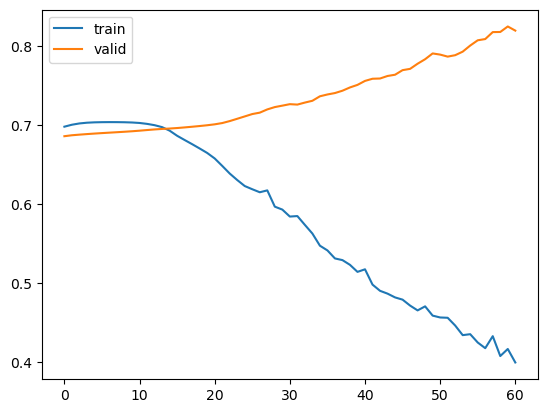

In [333]:
plt.plot( train_losses , label='train' )
plt.plot( valid_losses , label='valid' )
plt.legend()

tensor(0.7129, grad_fn=<BinaryCrossEntropyBackward0>)